In [1]:
import torch

from torchvision import utils

import processing

import dataset_processing

import get_data

import matplotlib.pyplot as plt

import numpy as np

import os

In [2]:
# read in the data
test_scene = 'gZ392ME3DDQPeX' 
path='/media/alexander/Elements/03_MLData/lightfields/all_lightfields'
data_folder   = path + '/' + str(test_scene)

LF            = get_data.read_lightfield(data_folder)
param_dict    = get_data.read_parameters(data_folder)
depth_map     = get_data.read_depth(data_folder, highres=False)
depth_all_map = get_data.read_all_depths(data_folder, highres=False)

np.shape(LF)

# convert the data to torch tensors
images     = torch.from_numpy(LF).permute([0,1,4,2,3]).float()/255.
depth_maps = torch.from_numpy(depth_all_map)

In [3]:
# jetzt naives rendering:
layers = 8

#images
image1 = images[6,7]
depth1 = depth_maps[6,7]

#image2 = images[7,3]
#depth2 = depth_maps[7,3]

image2 = images[2,7]
depth2 = depth_maps[2,7]

target_image = images[5,7]

#disp tensors 
disp_tensor1 = processing.create_disp_tensor(depth1, layers)[0]
disp_tensor2 = processing.create_disp_tensor(depth2, layers)[0]

#mpis 
mpi1 = processing.rgba(image1, disp_tensor1)
mpi2 = processing.rgba(image2, disp_tensor2)

#homography warp auf target pos [5,3]
#dafür brauchen wir die ganzen parameter

In [4]:
# Zusammengefasst:

# input : ein bild und zugehörige depth map, layers
image = images[3,3]
print(len(images))
depth = depth_maps[3,3]
layers = 8

# erzeuge disp tensor 
disp_tensor = processing.create_disp_tensor(depth, layers)[0]

#nehme disp tensor und bild und baue mpi
mpi = processing.rgba(image, disp_tensor)

#das können wir rekonstruieren
reconstruct = processing.back_to_front_alphacomposite(mpi)

# gleich?
torch.allclose(image, reconstruct[0:3])

9


True

In [5]:
param_dict['baselineMM']=param_dict['baseline_mm']
param_dict['focalLength'] = param_dict['focal_length_mm']
param_dict['sensorWidthMM'] = param_dict['sensor_size_mm']

param_dict['psv_center_1_pose']=[6,7]
param_dict['psv_center_2_pose']=[2,7]
param_dict['target_image_pose']=[5,7]

param_dict['mpi_1_min_disp']=1/depth1.max()
param_dict['mpi_2_min_disp']=1/depth2.max()

param_dict['mpi_1_bin_size']=((1/depth1).max()-(1/depth1).min())/layers
param_dict['mpi_2_bin_size']=((1/depth2).max()-(1/depth2).min())/layers

In [6]:
# jetzt der homography warp
mpis = torch.stack([mpi1, mpi2], dim=0)
target_mpis = processing.homography(mpis, param_dict)

# jetzt das alpha compositing
rgba1 = processing.back_to_front_alphacomposite(target_mpis[0])
rgba2 = processing.back_to_front_alphacomposite(target_mpis[1])

# jetzt das rendering als superposition der beiden
predicted_image = processing.blending_images_ourspecialcase(torch.stack((rgba1, rgba2), dim=0))

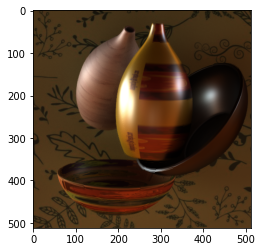

In [7]:
plt.imshow(predicted_image.permute(1, 2, 0))
plt.show()
predicted_image.shape
utils.save_image(tensor=predicted_image, fp='results/images/psvs_pred_' + dataset_processing.coords2string(param_dict['target_image_pose']) + '.png')

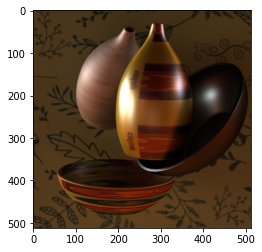

In [8]:
plt.imshow(target_image.permute(1, 2, 0))
plt.show()
target_image.shape
utils.save_image(tensor=target_image, fp='results/images/psvs_gt_' + dataset_processing.coords2string(param_dict['target_image_pose']) + '.png')

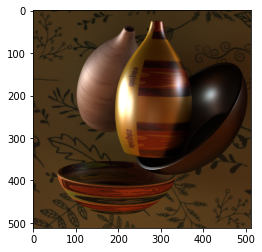

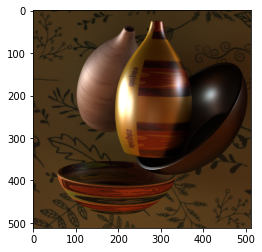

True

In [9]:
'Check if both images are equal'

# get image from lightfield dataset
image_original = images[8,8]
image_original.shape
plt.imshow(image_original.permute(1, 2, 0))
plt.show()
utils.save_image(tensor=image_original, fp='results/images/original.png')

# get image from our interal representation
image_ours = dataset_processing.get_target_image_from_disk(path, test_scene, (8,8))
image_ours.shape
plt.imshow(image_ours.detach().permute(1,2,0))
plt.show()
utils.save_image(tensor=image_ours, fp='results/images/ours.png')

#torch.eq(image_ours, image_original)
torch.allclose(image_original, image_ours)
